In [1]:
# Data handling and manipulation
import pandas as pd
import numpy as np
import re

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from textblob import TextBlob
from ucimlrepo import fetch_ucirepo

# Machine Learning and Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, PCA
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import hstack
import xgboost as xgb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load dataset
drug_reviews_drugs_com = fetch_ucirepo(id=462)
df1 = drug_reviews_drugs_com.data.features

In [3]:
# Convert 'date' column to datetime, forcing invalid entries to NaT
df1.loc[:, 'date'] = pd.to_datetime(df1['date'], errors='coerce')

# Filter records before 2015, ensuring we handle the case of time included in the datetime
df_pre_2015 = df1[df1['date'] < pd.Timestamp('2015-01-01')]

# Print number of rows and preview
num_rows = df_pre_2015.shape[0]
print(f"Number of rows in the filtered DataFrame: {num_rows}")
print(df_pre_2015.head())

# Display descriptive statistics for the filtered dataset
print(df_pre_2015.describe(include='all'))

/var/folders/_m/w66l765131l8253_28x9bp400000gp/T/ipykernel_57994/3413944466.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df1.loc[:, 'date'] = pd.to_datetime(df1['date'], errors='coerce')


Number of rows in the filtered DataFrame: 94953
      drugName                     condition  \
0    Valsartan  Left Ventricular Dysfunction   
1   Guanfacine                          ADHD   
2       Lybrel                 Birth Control   
12     Pentasa               Crohn's Disease   
14   Nexplanon                 Birth Control   

                                               review  rating  \
0   "It has no side effect, I take it in combinati...       9   
1   "My son is halfway through his fourth week of ...       8   
2   "I used to take another oral contraceptive, wh...       5   
12  "I had Crohn&#039;s with a resection 30 years ...       4   
14  "Started Nexplanon 2 months ago because I have...       3   

                   date  usefulCount  
0   2012-05-20 00:00:00           27  
1   2010-04-27 00:00:00          192  
2   2009-12-14 00:00:00           17  
12  2013-07-06 00:00:00            8  
14  2014-08-07 00:00:00           10  
                                 drugN

/var/folders/_m/w66l765131l8253_28x9bp400000gp/T/ipykernel_57994/3413944466.py:13: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  print(df_pre_2015.describe(include='all'))


## Exploratory Data Analysis (EDA)

In [5]:
df1.describe(include="all")

/var/folders/_m/w66l765131l8253_28x9bp400000gp/T/ipykernel_57994/4174339788.py:1: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  df1.describe(include="all")


,drugName,condition,review,rating,date,usefulCount
count,215063,213869,215063,215063.000000,215063,215063.000000
unique,3671,916,128478,NaN,3579,NaN
top,Levonorgestrel,Birth Control,"""Good""",NaN,2016-03-01 00:00:00,NaN
freq,4930,38436,39,NaN,185,NaN
mean,NaN,NaN,NaN,6.990008,NaN,28.001004
std,NaN,NaN,NaN,3.275554,NaN,36.346069
min,NaN,NaN,NaN,1.000000,NaN,0.000000
25%,NaN,NaN,NaN,5.000000,NaN,6.000000
50%,NaN,NaN,NaN,8.000000,NaN,16.000000
75%,NaN,NaN,NaN,10.000000,NaN,36.000000


In [6]:
df1.head()

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20 00:00:00,27
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27 00:00:00,192
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14 00:00:00,17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03 00:00:00,10
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27 00:00:00,37


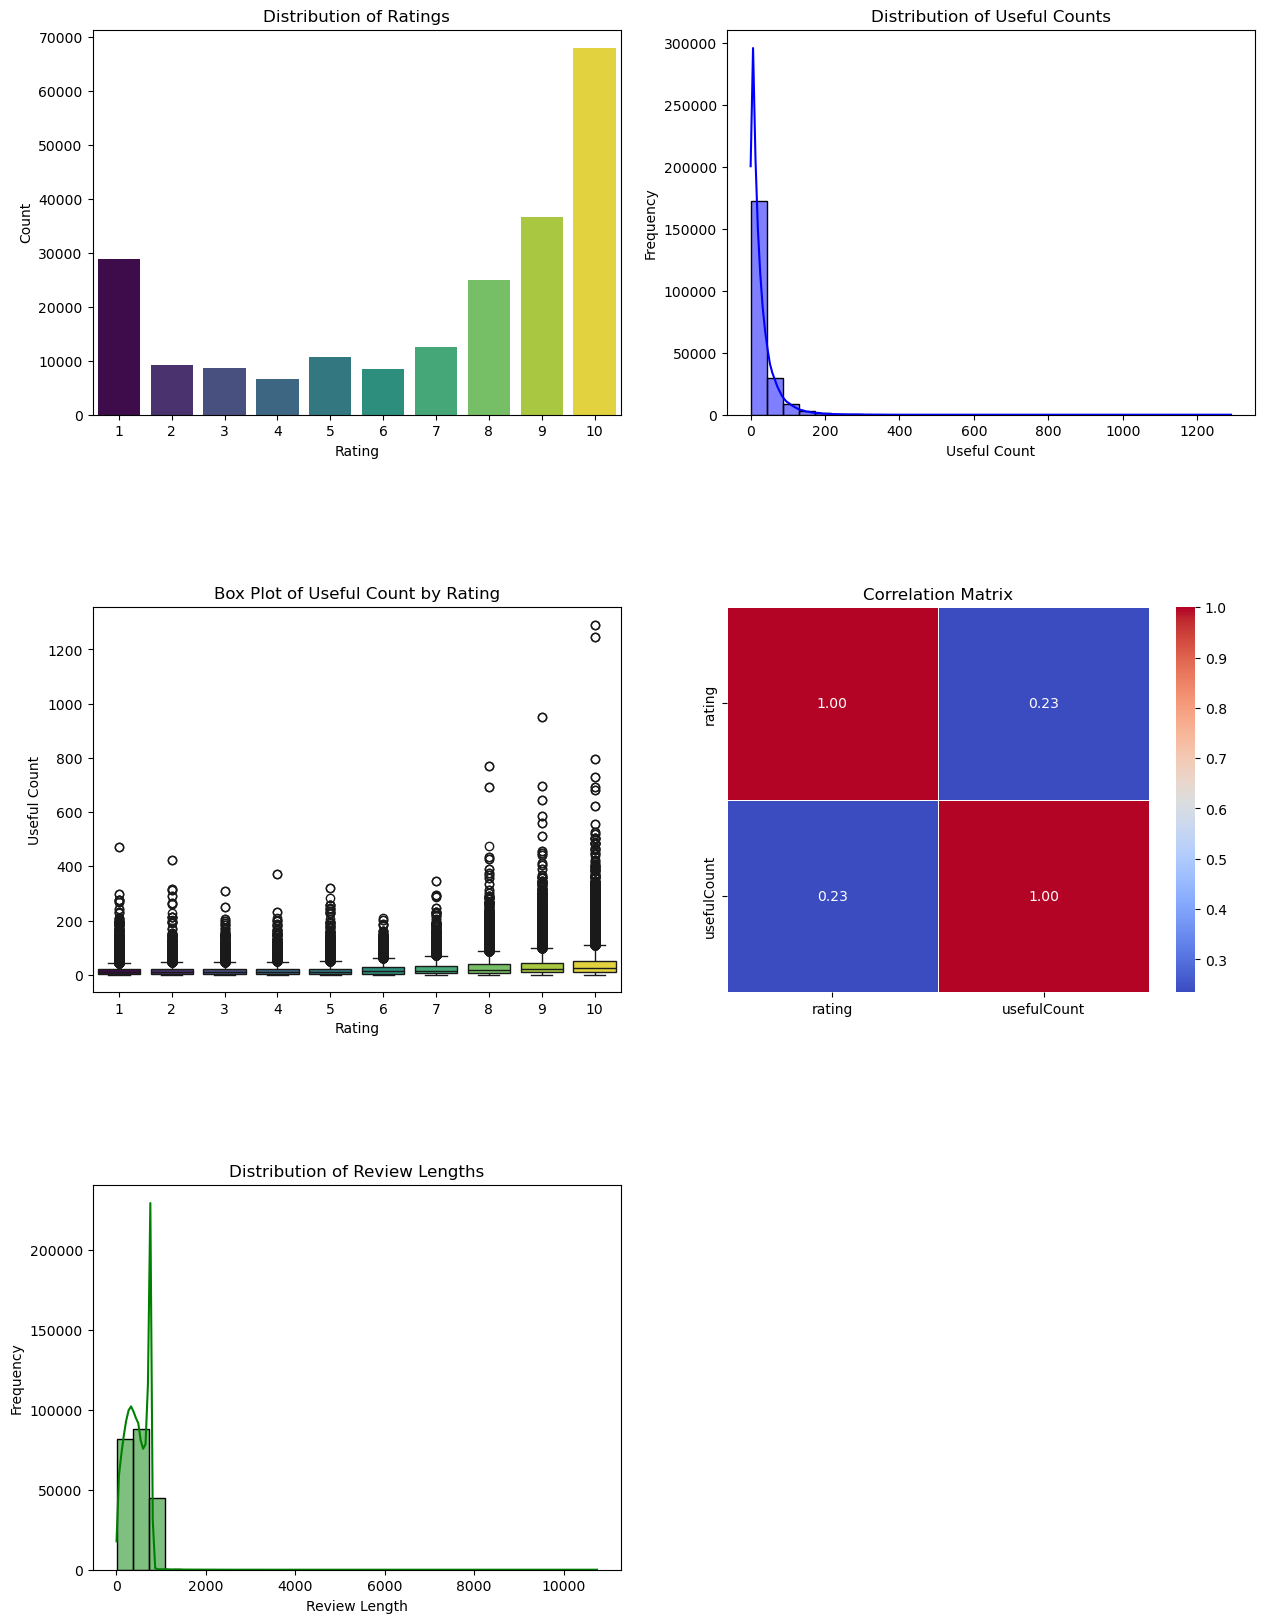

In [7]:
plt.figure(figsize=(15, 20))
plt.subplots_adjust(hspace=0.5)

# Distribution of Ratings
plt.subplot(3, 2, 1)
sns.countplot(data=df1, x='rating', hue='rating', palette='viridis', legend=False)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

#  Distribution of Useful Count
plt.subplot(3, 2, 2)
sns.histplot(df1['usefulCount'], bins=30, kde=True, color='blue')
plt.title('Distribution of Useful Counts')
plt.xlabel('Useful Count')
plt.ylabel('Frequency')

# Box Plot for Rating vs. Useful Count
plt.subplot(3, 2, 3)
sns.boxplot(x='rating', y='usefulCount', data=df1, hue='rating', palette='viridis', legend=False)
plt.title('Box Plot of Useful Count by Rating')
plt.xlabel('Rating')
plt.ylabel('Useful Count')

# Correlation Matrix
plt.subplot(3, 2, 4)
numeric_df1 = df1.select_dtypes(include=[np.number])
correlation_matrix = numeric_df1.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')

# Review Length Statistics
df1['review_length'] = df1['review'].astype(str).apply(len)
plt.subplot(3, 2, 5)
sns.histplot(df1['review_length'], bins=30, kde=True, color='green')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')

plt.show()

/var/folders/_m/w66l765131l8253_28x9bp400000gp/T/ipykernel_57994/3640039016.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x=condition_reviews.values, y=condition_reviews.index, palette='viridis')
/var/folders/_m/w66l765131l8253_28x9bp400000gp/T/ipykernel_57994/3640039016.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x=drug_reviews.values, y=drug_reviews.index, palette='viridis')


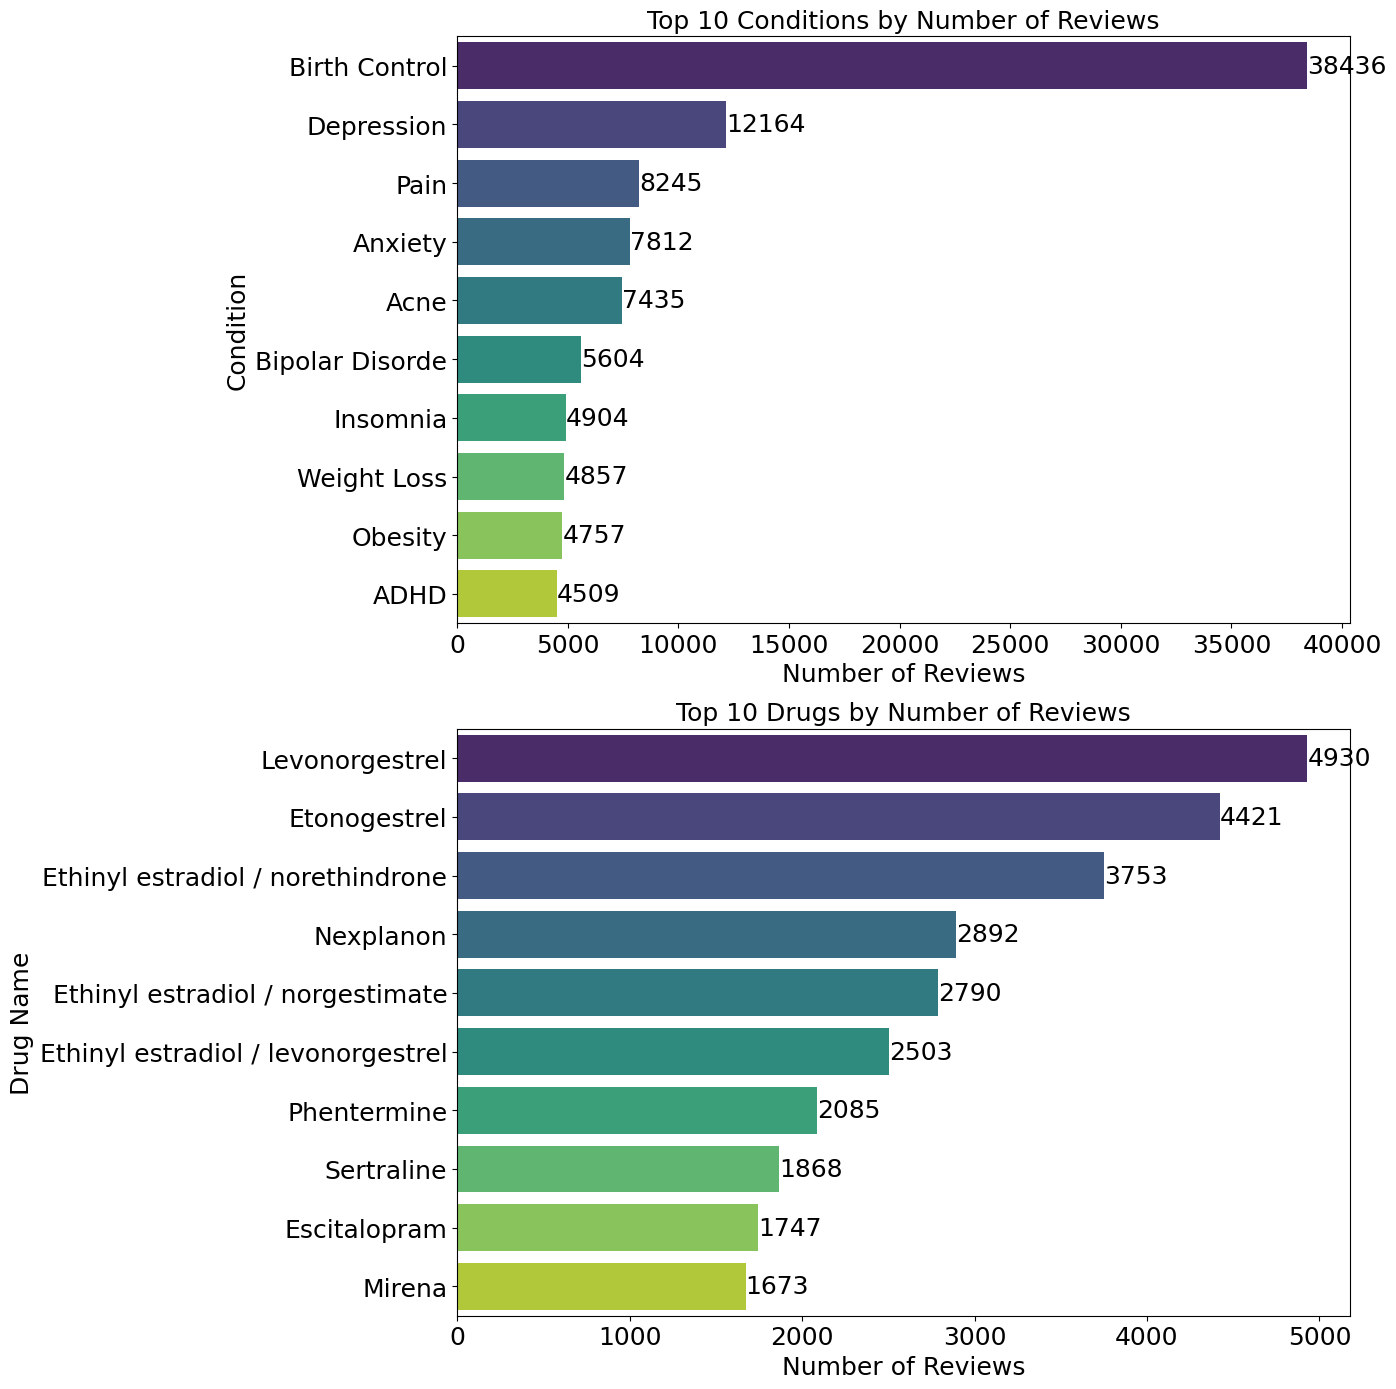

In [8]:
# Count top N most frequent conditions and their review counts
top_conditions = df1['condition'].value_counts().head(10)

# Count the number of reviews for each condition
condition_reviews = df1.groupby('condition')['review'].count().loc[top_conditions.index]

# Count top N most frequent drug names and their review counts
top_drugs = df1['drugName'].value_counts().head(10)

# Count the number of reviews for each drug
drug_reviews = df1.groupby('drugName')['review'].count().loc[top_drugs.index]

# Set up the matplotlib figure size
plt.figure(figsize=(14, 14))

# Create a subplot for conditions
plt.subplot(2, 1, 1)
ax1 = sns.barplot(x=condition_reviews.values, y=condition_reviews.index, palette='viridis')
plt.title("Top 10 Conditions by Number of Reviews", fontsize=18)
plt.xlabel("Number of Reviews", fontsize=18)
plt.ylabel("Condition", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Annotate the bars with counts for conditions
for container in ax1.containers:
    ax1.bar_label(container, fmt='%d', fontsize=18)

# Create a subplot for drugs
plt.subplot(2, 1, 2)
ax2 = sns.barplot(x=drug_reviews.values, y=drug_reviews.index, palette='viridis')
plt.title("Top 10 Drugs by Number of Reviews", fontsize=18)
plt.xlabel("Number of Reviews", fontsize=18)
plt.ylabel("Drug Name", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Annotate the bars with counts for drugs
for container in ax2.containers:
    ax2.bar_label(container, fmt='%d', fontsize=18)

# Adjust layout
plt.tight_layout()
plt.show()


/var/folders/_m/w66l765131l8253_28x9bp400000gp/T/ipykernel_57994/2916134370.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='drugName', y='usefulCount', data=df_top_n, estimator=np.mean, errorbar=None, palette='viridis', dodge=True)


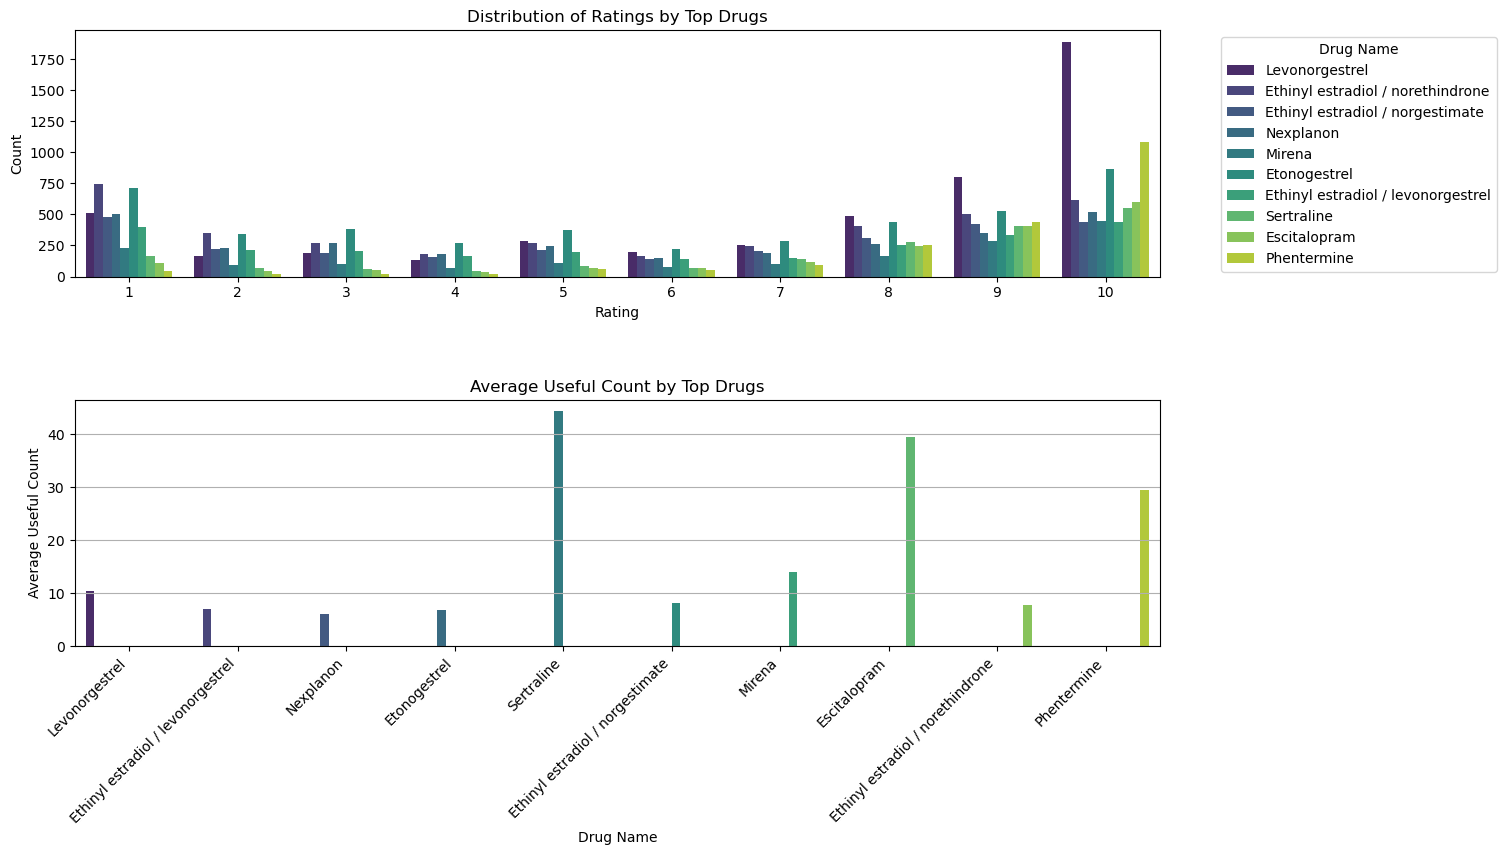

In [9]:
# Descriptive Statistics by Drug
drug_stats = df1.groupby('drugName').agg({
    'rating': ['mean', 'std', 'min', 'max', 'count'],
    'usefulCount': ['mean', 'std', 'min', 'max'],
    'review': 'count'
}).reset_index()

# Limit to top N drugs based on review count
top_n = drug_stats.nlargest(10, ('rating', 'count'))['drugName']
df_top_n = df1[df1['drugName'].isin(top_n)]


plt.figure(figsize=(14, 8)) 
plt.subplots_adjust(hspace=0.5)

# Distribution of Ratings by Top Drugs
plt.subplot(2, 1, 1)
sns.countplot(data=df_top_n, x='rating', hue='drugName', palette='viridis', dodge=True)
plt.title('Distribution of Ratings by Top Drugs')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.legend(title='Drug Name', bbox_to_anchor=(1.05, 1), loc='upper left')

# Average Useful Count by Top Drugs
plt.subplot(2, 1, 2)
sns.barplot(x='drugName', y='usefulCount', data=df_top_n, estimator=np.mean, errorbar=None, palette='viridis', dodge=True)
plt.title('Average Useful Count by Top Drugs')
plt.xlabel('Drug Name')
plt.ylabel('Average Useful Count')
plt.xticks(rotation=45, ha='right') 
plt.grid(axis='y')

# Show plot
plt.show()

In [10]:
# Convert 'date' to datetime if not already done, specifying a format if known
df1['date'] = pd.to_datetime(df1['date'], format='%Y-%m-%d', errors='coerce')

# Extract year and month for aggregation
df1['year_month'] = df1['date'].dt.to_period('M')

# Average rating per month
monthly_ratings = df1.groupby('year_month')['rating'].mean().reset_index()
monthly_ratings['rating'] = monthly_ratings['rating'].round(2)  # Round ratings for clarity

# Total useful counts per month
monthly_useful_counts = df1.groupby('year_month')['usefulCount'].sum().reset_index()
monthly_summary = pd.merge(monthly_ratings, monthly_useful_counts, on='year_month', suffixes=('_rating', '_usefulCount'))

# Display the result
monthly_summary

,year_month,rating,usefulCount
0,2008-02,7.20,11901
1,2008-03,8.54,56369
2,2008-04,8.97,51389
3,2008-05,9.07,38837
4,2008-06,9.11,42265
...,...,...,...
114,2017-08,5.96,25264
115,2017-09,6.06,18959
116,2017-10,6.02,11851
117,2017-11,5.72,4180


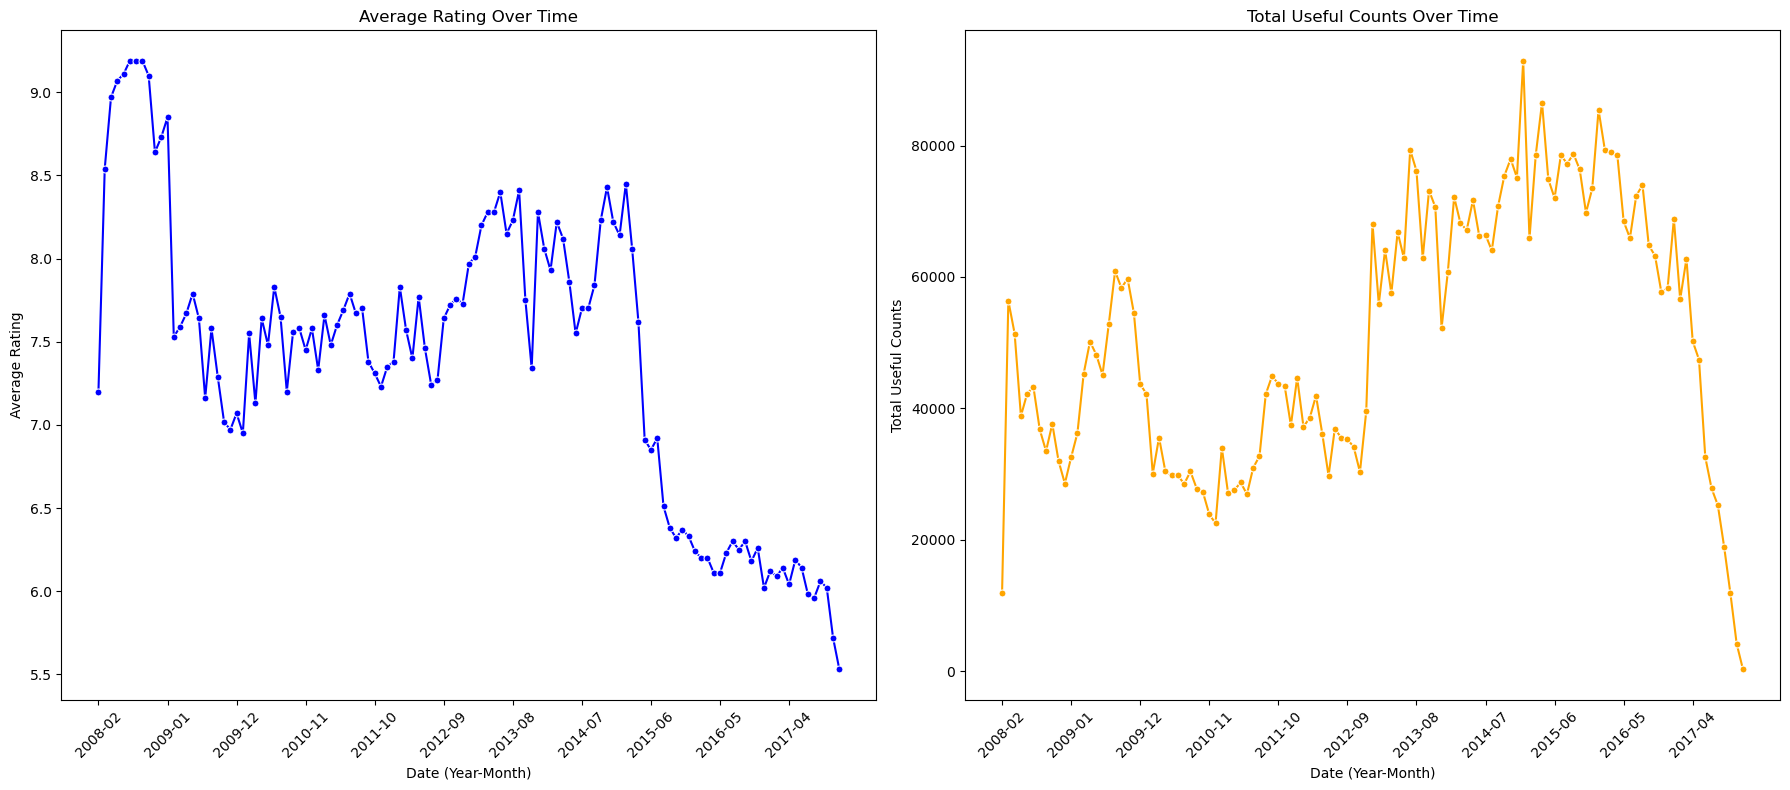

In [11]:
# Convert 'year_month' to string for plotting
monthly_ratings['year_month'] = monthly_ratings['year_month'].astype(str)
monthly_useful_counts['year_month'] = monthly_useful_counts['year_month'].astype(str)

plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
sns.lineplot(data=monthly_ratings, x='year_month', y='rating', marker='o', color='blue', markersize=5)
plt.title('Average Rating Over Time')
plt.xlabel('Date (Year-Month)')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)

# Limit the number of x-ticks
plt.xticks(ticks=range(0, len(monthly_ratings['year_month']), max(1, len(monthly_ratings['year_month']) // 10)), 
           labels=monthly_ratings['year_month'][::max(1, len(monthly_ratings['year_month']) // 10)], rotation=45)

# Plotting Total Useful Counts
plt.subplot(1, 2, 2)
sns.lineplot(data=monthly_useful_counts, x='year_month', y='usefulCount', marker='o', color='orange', markersize=5)
plt.title('Total Useful Counts Over Time')
plt.xlabel('Date (Year-Month)')
plt.ylabel('Total Useful Counts')
plt.xticks(rotation=45)

# Limit the number of x-ticks
plt.xticks(ticks=range(0, len(monthly_useful_counts['year_month']), max(1, len(monthly_useful_counts['year_month']) // 10)), 
           labels=monthly_useful_counts['year_month'][::max(1, len(monthly_useful_counts['year_month']) // 10)], rotation=45)

plt.tight_layout()
plt.show()

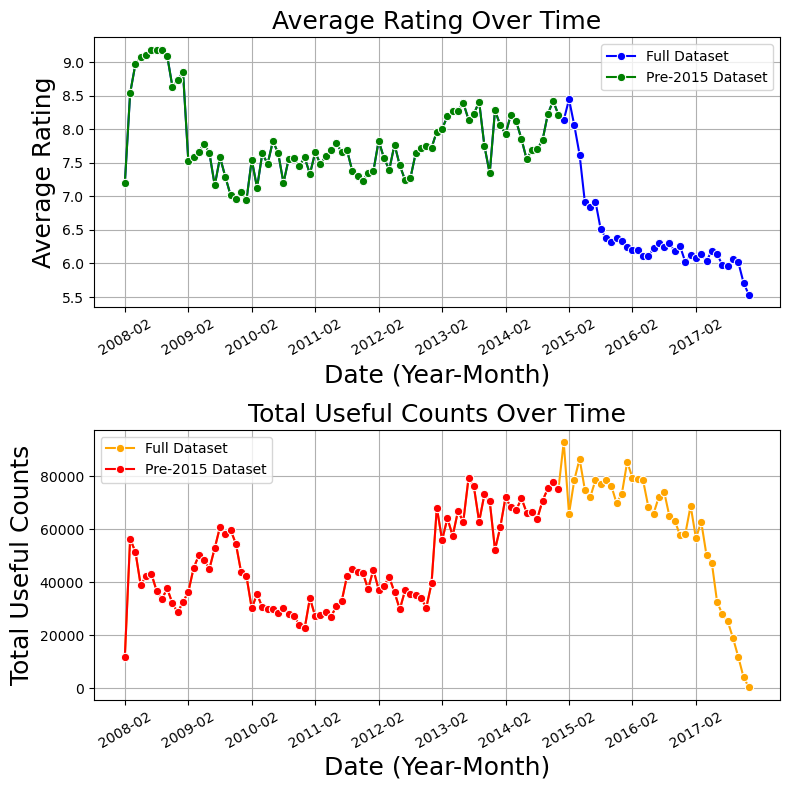

In [12]:
# Ensure 'date' column is in datetime format
df1['date'] = pd.to_datetime(df1['date'], errors='coerce')  # Convert to datetime, invalid parsing will be set to NaT

# Filter the data pre-2015
df_pre_2015 = df1[df1['date'].dt.year < 2015].copy() 

# Create 'year_month' column for aggregation
df1['year_month'] = df1['date'].dt.to_period('M').astype(str)
df_pre_2015['year_month'] = df_pre_2015['date'].dt.to_period('M').astype(str)

# Aggregation
monthly_ratings = df1.groupby('year_month')['rating'].mean().reset_index()
monthly_useful_counts = df1.groupby('year_month')['usefulCount'].sum().reset_index()

monthly_ratings_filtered = df_pre_2015.groupby('year_month')['rating'].mean().reset_index()
monthly_useful_counts_filtered = df_pre_2015.groupby('year_month')['usefulCount'].sum().reset_index()

# Combined Plot
plt.figure(figsize=(8, 8))

# Function to control x-tick intervals
def reduce_xticks(data, step=12):
    """Reduce x-ticks by step."""
    ticks = range(0, len(data['year_month']), step)
    labels = data['year_month'][ticks]
    return ticks, labels

# Plot for Average Ratings
plt.subplot(2, 1, 1)
sns.lineplot(data=monthly_ratings, x='year_month', y='rating', label='Full Dataset', color='blue', marker='o')
sns.lineplot(data=monthly_ratings_filtered, x='year_month', y='rating', label='Pre-2015 Dataset', color='green', marker='o')
ticks, labels = reduce_xticks(monthly_ratings, step=12)
plt.xticks(ticks=ticks, labels=labels, rotation=30)
plt.title('Average Rating Over Time', fontsize=18)
plt.xlabel('Date (Year-Month)', fontsize=18)
plt.ylabel('Average Rating', fontsize=18)
plt.legend()
plt.grid(True)

# Plot for Total Useful Counts
plt.subplot(2, 1, 2)
sns.lineplot(data=monthly_useful_counts, x='year_month', y='usefulCount', label='Full Dataset', color='orange', marker='o')
sns.lineplot(data=monthly_useful_counts_filtered, x='year_month', y='usefulCount', label='Pre-2015 Dataset', color='red', marker='o')
ticks, labels = reduce_xticks(monthly_useful_counts, step=12)
plt.xticks(ticks=ticks, labels=labels,rotation=30)
plt.title('Total Useful Counts Over Time', fontsize=18)
plt.xlabel('Date (Year-Month)', fontsize=18)
plt.ylabel('Total Useful Counts', fontsize=18)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

/var/folders/_m/w66l765131l8253_28x9bp400000gp/T/ipykernel_57994/565665958.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sentiment_counts_df, x='sentiment_category', y='count', palette='pastel')


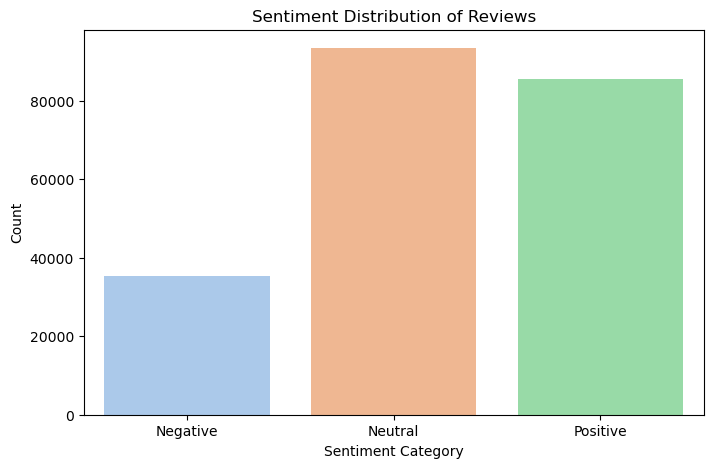

In [16]:
# Function to calculate sentiment
def get_sentiment(review):
    return TextBlob(review).sentiment.polarity  

# Apply sentiment function to reviews
df1['sentiment'] = df1['review'].apply(get_sentiment)

# Descriptive statistics for sentiment
sentiment_desc = df1['sentiment'].describe()

# Categorize sentiment
df1['sentiment_category'] = pd.cut(df1['sentiment'], bins=[-1, -0.1, 0.1, 1], 
                                    labels=['Negative', 'Neutral', 'Positive'])

# Sentiment distribution
sentiment_counts = df1['sentiment_category'].value_counts()

# Create a DataFrame for sentiment counts
sentiment_counts_df = sentiment_counts.reset_index()
sentiment_counts_df.columns = ['sentiment_category', 'count']

# Plot sentiment distribution
plt.figure(figsize=(8, 5))
sns.barplot(data=sentiment_counts_df, x='sentiment_category', y='count', palette='pastel')
plt.title('Sentiment Distribution of Reviews')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

# # Plot effectiveness distribution from combined_df
# plt.figure(figsize=(9, 5))
# sns.countplot(data=df1, x='effectiveness', palette='plasma')
# plt.title('Effectiveness Distribution')
# plt.xlabel('Effectiveness')
# plt.ylabel('Count')
# plt.xticks(rotation=45)
# plt.show()


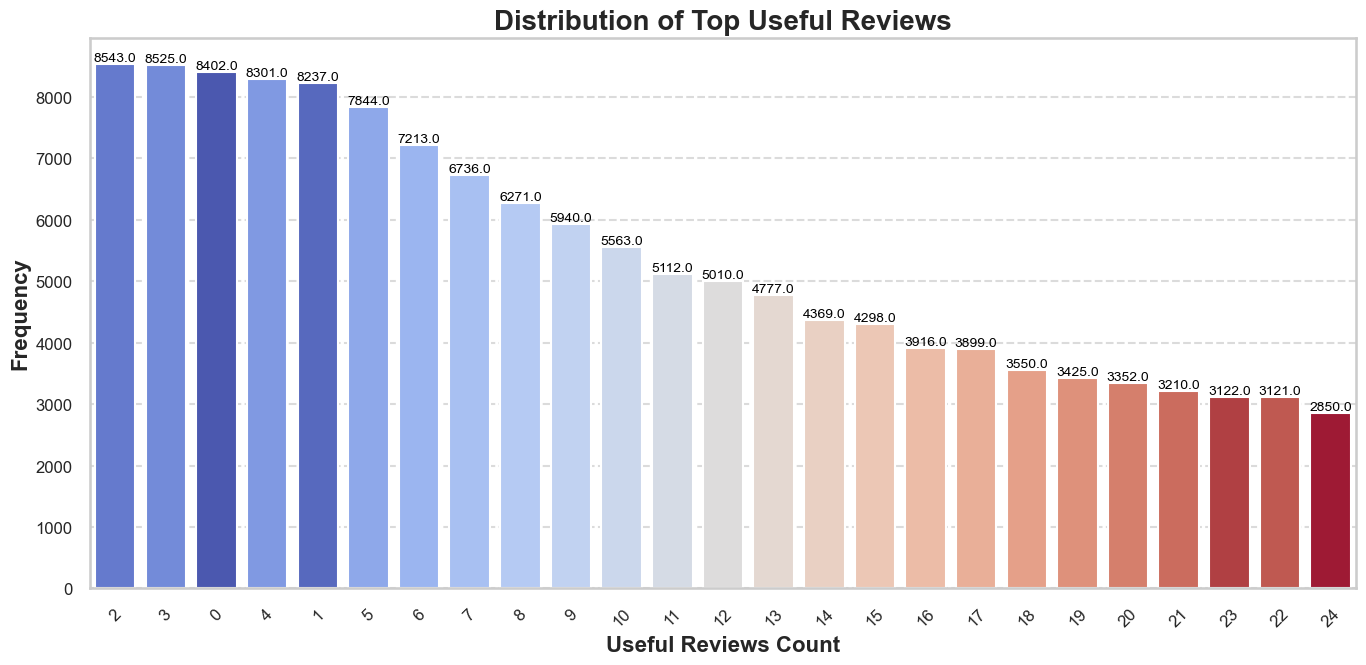

In [17]:
# Set the style and context of the plot
sns.set(style="whitegrid", context="talk")

# Determine the top N useful review counts
top_n = 25 
top_useful_counts = df1['usefulCount'].value_counts().nlargest(top_n)

plt.figure(figsize=(14, 7))

# Filter df1 based on its own usefulCount column
filtered_data = df1[df1['usefulCount'].isin(top_useful_counts.index)]

# Create the count plot without palette warning
sns.countplot(data=filtered_data,
              x='usefulCount', 
              order=top_useful_counts.index,
              hue='usefulCount',  # Assigning hue for color differentiation
              palette='coolwarm', 
              legend=False)  # Disable legend if not needed

# Add titles and labels with increased font sizes
plt.title('Distribution of Top Useful Reviews', fontsize=20, weight='bold')
plt.xlabel('Useful Reviews Count', fontsize=16, weight='bold')
plt.ylabel('Frequency', fontsize=16, weight='bold')

# Enhance x-tick labels
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with their counts
for p in plt.gca().patches:
    plt.annotate(f'{p.get_height()}', 
                 (p.get_x() + p.get_width() / 2., 
                  p.get_height()), 
                 ha='center', va='bottom', 
                 fontsize=10, color='black')

plt.tight_layout() 
plt.show()


In [18]:
def rename_columns(df):
    df = df.rename(columns={
        'urlDrugName': 'drug_name',
        'sideEffects': 'side_effects',
        'benefitsReview': 'benefits_review',
        'sideEffectsReview': 'side_effects_review',
        'commentsReview': 'comments_review'  
    })
    return df

# Rename columns in both DataFrames
df1 = rename_columns(df1)
df1_pre2015 = rename_columns(df_pre_2015)

# Check the column names after renaming
print("Columns in Dataset 1:", df1.columns)

Columns in Dataset 1: Index(['drugName', 'condition', 'review', 'rating', 'date', 'usefulCount',
       'review_length', 'year_month', 'sentiment', 'sentiment_category'],
      dtype='object')


In [19]:
def plot_drug_ratings(df, dataset_name, top_n=30):
    plt.figure(figsize=(12, 6))
    
    # Check if drug_name exists 
    if 'drug_name' in df.columns:
        # Get the top N drugs based on count
        top_drugs = df['drug_name'].value_counts().nlargest(top_n).index
        sns.countplot(data=df[df['drug_name'].isin(top_drugs)], x='drug_name', order=top_drugs)
        plt.title(f'Top {top_n} Drug Ratings Count in {dataset_name}')
        plt.xticks(rotation=90)
        plt.show()
    else:
        print(f"'drug_name' column not found in {dataset_name}.")

# Plot for both datasets
plot_drug_ratings(df1, "Dataset 1", top_n=30)

'drug_name' column not found in Dataset 1.


<Figure size 1200x600 with 0 Axes>

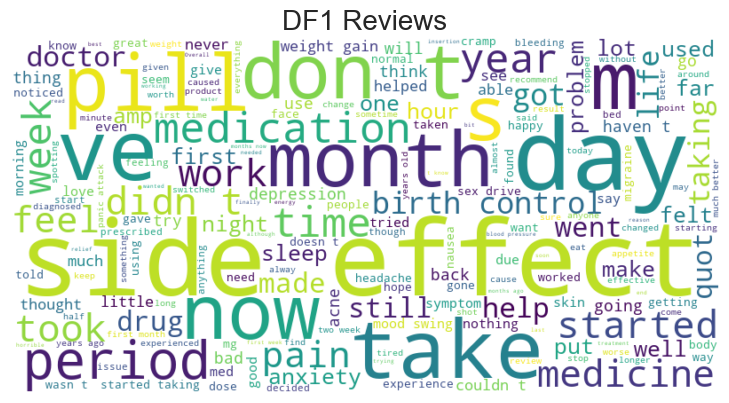

In [20]:
df1_reviews = ' '.join(df1['review'].dropna().astype(str))
wordcloud_df1 = WordCloud(width=800, height=400, background_color='white').generate(df1_reviews)

# Set up the plot for both word clouds
plt.figure(figsize=(15, 10))

# Plot for df1
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_df1, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.title("DF1 Reviews", fontsize=20)

# Show the plots
plt.tight_layout()
plt.show()

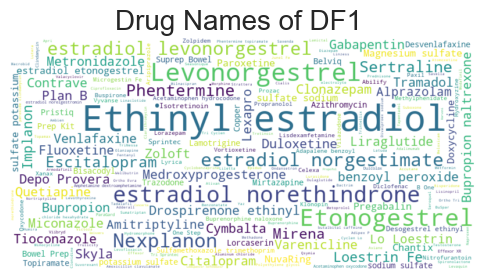

In [50]:
# Generate word cloud for df1 drug names
df1_drug_names = ' '.join(df1['drugName'].dropna().astype(str))
wordcloud_df1 = WordCloud(width=800, height=400, background_color='white').generate(df1_drug_names)

# Set up the plot for all three word clouds
plt.figure(figsize=(15, 10))

# Plot for df1
plt.subplot(1, 3, 1)
plt.imshow(wordcloud_df1, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.title("Drug Names of DF1 ", fontsize=20)

# Show the plots
plt.tight_layout()
plt.show()


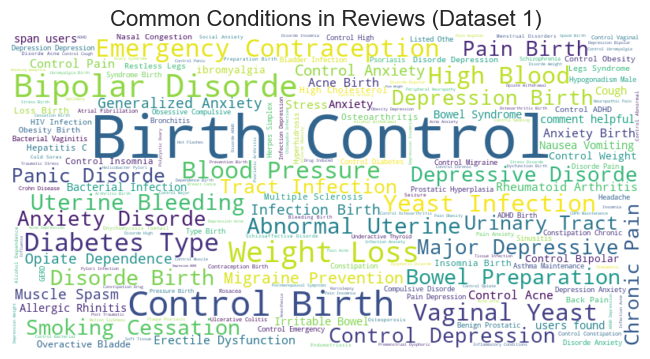

In [51]:
# Generate word cloud for conditions in df1
condition_text_df1 = ' '.join(df1['condition'].dropna())
wordcloud_conditions_df1 = WordCloud(width=800, height=400, background_color='white').generate(condition_text_df1)

# Set up the plot for all three word clouds
plt.figure(figsize=(20, 7))

# Plot for conditions in df1
plt.subplot(1, 3, 1)
plt.imshow(wordcloud_conditions_df1, interpolation='bilinear')
plt.axis('off')
plt.title('Common Conditions in Reviews (Dataset 1)', fontsize=16)

# Show the plots
plt.tight_layout()
plt.show()



# NLP DATA PROCESSING

In [53]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to clean text (remove punctuation, lowercase, remove numbers)
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Function to tokenize and remove stopwords
def tokenize_and_remove_stopwords(text):
    if isinstance(text, str):
        words = word_tokenize(text)
        words = [word for word in words if word not in stop_words]
        return words
    return []  

# Function to lemmatize words
def lemmatize_words(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

# Apply the text cleaning, tokenization, and lemmatization to df1 (full dataset)
df1['cleaned_review'] = df1['review'].apply(clean_text)
df1['tokens_review'] = df1['cleaned_review'].apply(tokenize_and_remove_stopwords)
df1['lemmatized_review'] = df1['tokens_review'].apply(lemmatize_words)

# Apply the text cleaning, tokenization, and lemmatization to (filtered pre-2015 dataset)
df1_pre2015['cleaned_review'] = df1_pre2015['review'].apply(clean_text)
df1_pre2015['tokens_review'] = df1_pre2015['cleaned_review'].apply(tokenize_and_remove_stopwords)
df1_pre2015['lemmatized_review'] = df1_pre2015['tokens_review'].apply(lemmatize_words)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nidhihosamane/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nidhihosamane/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nidhihosamane/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


TF-IDF matrix shape: (215063, 500)
Top TF-IDF terms:
 day       0.054130
month     0.042913
year      0.042557
pain      0.039958
effect    0.039835
week      0.038042
im        0.036984
taking    0.036665
mg        0.035442
work      0.034980
dtype: float64


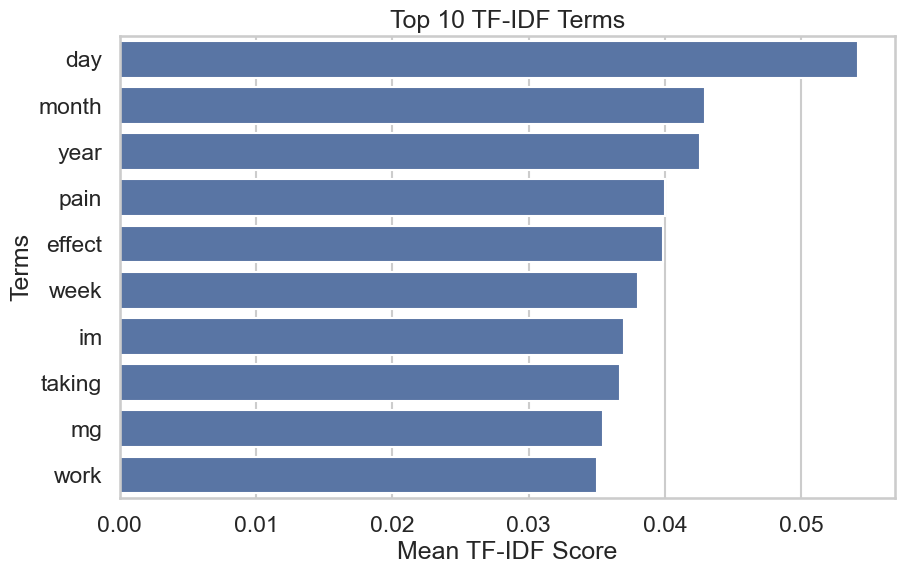

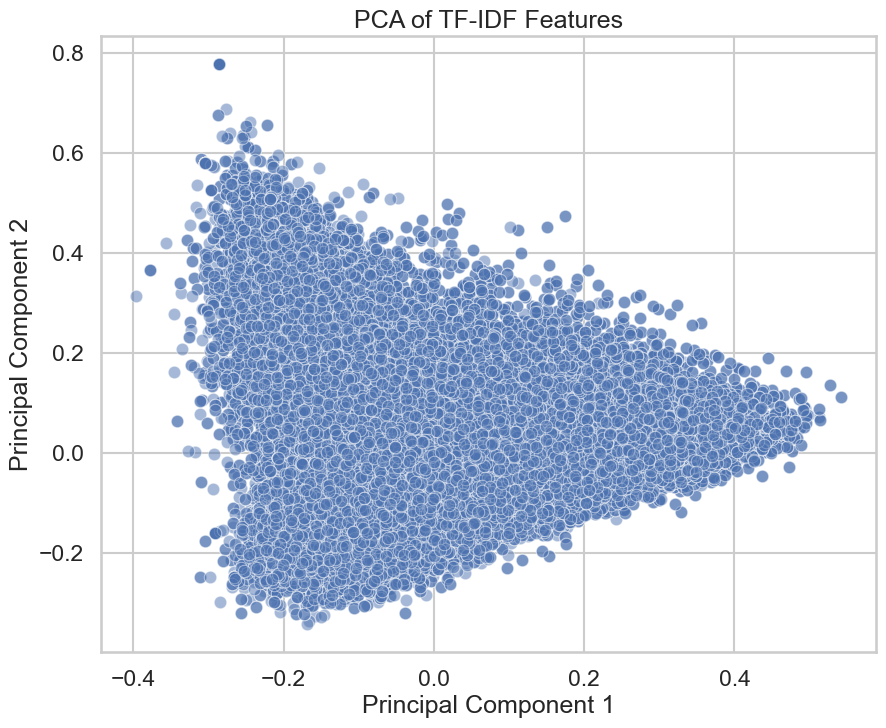

In [54]:
# Check for the lemmatized review column
if 'lemmatized_review' in df1.columns:
    # Use the entire dataset for TF-IDF
    text_column = df1['lemmatized_review'].astype(str)
    
    # Initialize TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
    X_tfidf = tfidf_vectorizer.fit_transform(text_column)

    # Display the shape of the TF-IDF matrix
    print("TF-IDF matrix shape:", X_tfidf.shape)

    # Convert to DataFrame for easier analysis
    tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
    
    # Display top terms by their mean TF-IDF score
    mean_tfidf_scores = tfidf_df.mean().sort_values(ascending=False)
    print("Top TF-IDF terms:\n", mean_tfidf_scores.head(10))

    # Visualize the top TF-IDF terms
    plt.figure(figsize=(10, 6))
    sns.barplot(x=mean_tfidf_scores.head(10).values, y=mean_tfidf_scores.head(10).index)
    plt.title('Top 10 TF-IDF Terms')
    plt.xlabel('Mean TF-IDF Score')
    plt.ylabel('Terms')
    plt.show()

    # Dimensionality reduction using PCA for visualization
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(X_tfidf.toarray())

    # Create a DataFrame for the PCA result
    pca_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])

    # Visualize PCA results
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PC1', y='PC2', data=pca_df, alpha=0.5)
    plt.title('PCA of TF-IDF Features')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()


In [55]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment score
def analyze_sentiment(text):
    if isinstance(text, str):
        return sia.polarity_scores(text)
    else:
        return {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}

# Ensure that you have a column with the raw reviews, for example, 'review'
if 'review' in df1.columns:
    # Apply sentiment analysis to the raw review column
    df1['comments_review_sentiment'] = df1['review'].apply(analyze_sentiment)

    # Extract compound sentiment score
    df1['comments_sentiment_score'] = df1['comments_review_sentiment'].apply(lambda x: x['compound'])

    # Check the distribution of sentiment scores
    print("Sentiment score distribution:")
    print(df1['comments_sentiment_score'].describe())

    # Print sentiment scores for the top n rows
    print("Sentiment scores for comments reviews:")
    print(df1[['review', 'comments_sentiment_score']].head(10))

    # Identify reviews with significant sentiment scores
    significant_sentiment = df1[df1['comments_sentiment_score'].abs() > 0.1]  # Adjust the threshold as needed
    print("Reviews with significant sentiment scores:")
    print(significant_sentiment[['review', 'comments_sentiment_score']].head(5))


Sentiment score distribution:
count    215063.000000
mean         -0.042509
std           0.680252
min          -0.998400
25%          -0.726900
50%          -0.050700
75%           0.636900
max           0.995200
Name: comments_sentiment_score, dtype: float64
Sentiment scores for comments reviews:
                                              review  comments_sentiment_score
0  "It has no side effect, I take it in combinati...                   -0.2960
1  "My son is halfway through his fourth week of ...                    0.8603
2  "I used to take another oral contraceptive, wh...                    0.7962
3  "This is my first time using any form of birth...                    0.7184
4  "Suboxone has completely turned my life around...                    0.9403
5  "2nd day on 5mg started to work with rock hard...                   -0.4342
6  "He pulled out, but he cummed a bit in me. I t...                    0.0000
7  "Abilify changed my life. There is hope. I was...                

In [56]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment score
def analyze_sentiment(text):
    if isinstance(text, str):
        return sia.polarity_scores(text)
    else:
        return {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}

# Apply sentiment analysis to the entire DataFrame
df1['comments_review_sentiment'] = df1['lemmatized_review'].apply(analyze_sentiment)

# Extract compound sentiment score
df1['comments_sentiment_score'] = df1['comments_review_sentiment'].apply(lambda x: x['compound'])

# Check the distribution of sentiment scores
print("Sentiment score distribution:")
print(df1['comments_sentiment_score'].describe())

# Print sentiment scores for the top 30 rows
print("Sentiment scores for comments reviews:")
print(df1[['lemmatized_review', 'comments_sentiment_score']].head(15))

# Identify reviews with significant sentiment scores
significant_sentiment = df1[df1['comments_sentiment_score'].abs() > 0.1]  # Adjust the threshold as needed
print("Reviews with significant sentiment scores:")
print(significant_sentiment[['lemmatized_review', 'comments_sentiment_score']].head(5))



Sentiment score distribution:
count    215063.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: comments_sentiment_score, dtype: float64
Sentiment scores for comments reviews:
                                    lemmatized_review  \
0   [side, effect, take, combination, bystolic, mg...   
1   [son, halfway, fourth, week, intuniv, became, ...   
2   [used, take, another, oral, contraceptive, pil...   
3   [first, time, using, form, birth, control, im,...   
4   [suboxone, completely, turned, life, around, f...   
5   [nd, day, mg, started, work, rock, hard, erect...   
6   [pulled, cummed, bit, took, plan, b, hour, lat...   
7   [abilify, changed, life, hope, zoloft, clonidi...   
8   [nothing, problem, keppera, constant, shaking,...   
9   [pill, many, year, doctor, changed, rx, chatea...   
10  [medication, almost, two, week, started, mg, w...   
11  [taken, antidepressant, year, improvement, mos...   

In [57]:
from sklearn.cluster import KMeans

 # Use TF-IDF for feature extraction
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(df1['review'].astype(str))

# Apply K-means clustering
n_clusters = 5  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df1['cluster'] = kmeans.fit_predict(X_tfidf)

# Print cluster assignments
print("Cluster assignments for reviews:")
print(df1[['review', 'cluster']].head(5))


Cluster assignments for reviews:
                                              review  cluster
0  "It has no side effect, I take it in combinati...        1
1  "My son is halfway through his fourth week of ...        1
2  "I used to take another oral contraceptive, wh...        4
3  "This is my first time using any form of birth...        4
4  "Suboxone has completely turned my life around...        1


In [58]:
# Use TF-IDF for feature extraction
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(df1['lemmatized_review'].astype(str))

# Apply K-means clustering
n_clusters = 5  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df1['cluster'] = kmeans.fit_predict(X_tfidf)

# Print cluster assignments
print("Cluster assignments for lemmatized reviews:")
print(df1[['lemmatized_review', 'cluster']].head(5))

Cluster assignments for lemmatized reviews:
                                   lemmatized_review  cluster
0  [side, effect, take, combination, bystolic, mg...        4
1  [son, halfway, fourth, week, intuniv, became, ...        4
2  [used, take, another, oral, contraceptive, pil...        2
3  [first, time, using, form, birth, control, im,...        2
4  [suboxone, completely, turned, life, around, f...        4


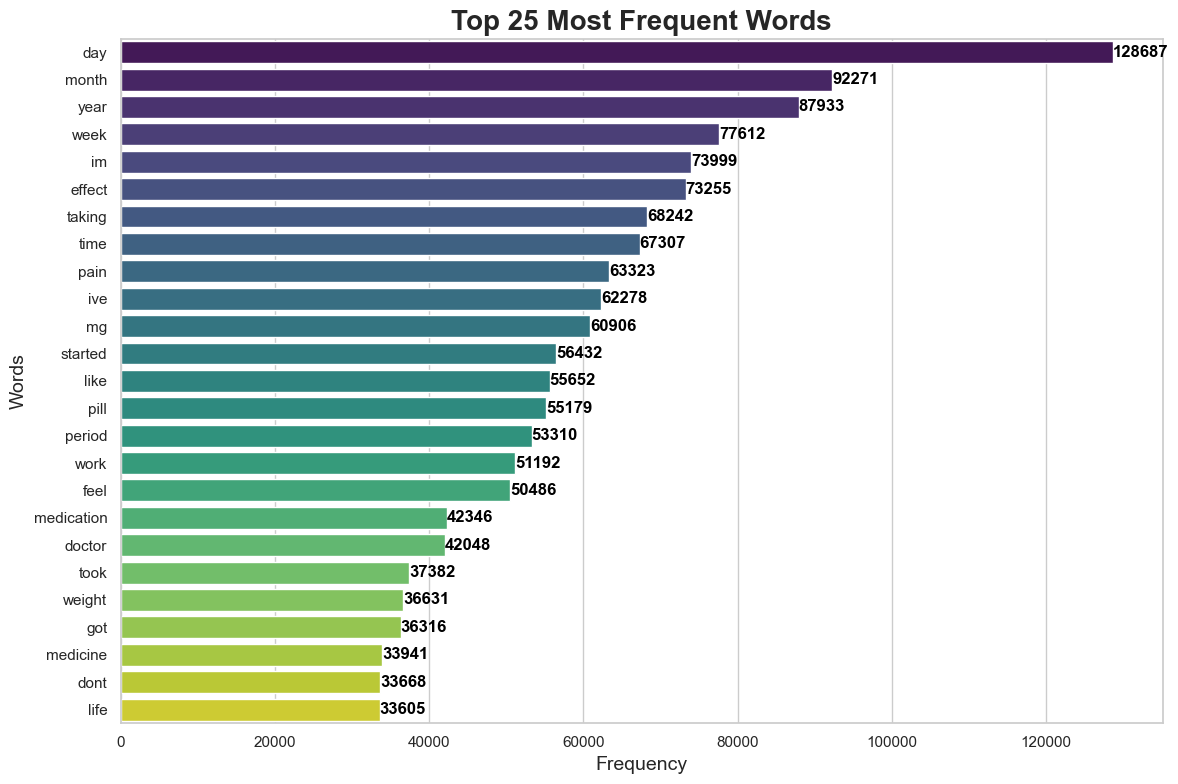

In [59]:
# Function to plot most frequent words
def plot_most_frequent_words(text_column, top_n=20):
    # Use CountVectorizer to get word frequencies
    vectorizer = CountVectorizer(stop_words='english', max_features=top_n)
    word_matrix = vectorizer.fit_transform(text_column)
    word_freq = np.asarray(word_matrix.sum(axis=0)).flatten()
    words = vectorizer.get_feature_names_out()

    # Create a DataFrame for plotting
    word_freq_dict = dict(zip(words, word_freq))
    sorted_words = sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True)
    word_df = pd.DataFrame(sorted_words, columns=['Word', 'Frequency'])

    # Set up the plot
    plt.figure(figsize=(12, 8))
    sns.set_theme(style='whitegrid', palette='pastel')

    # Create a horizontal bar plot with hue
    bar_plot = sns.barplot(x='Frequency', y='Word', data=word_df, hue='Word', palette='viridis', legend=False)
    plt.title(f'Top {top_n} Most Frequent Words', fontsize=20, weight='bold')
    plt.xlabel('Frequency', fontsize=14)
    plt.ylabel('Words', fontsize=14)

    # Add value annotations on the bars with more styling
    for index, value in enumerate(word_df['Frequency']):
        bar_plot.text(value, index, f'{value}', color='black', ha='left', va='center', fontsize=12, weight='bold')

    # Enhance layout with tight layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Check for the lemmatized review column
if 'lemmatized_review' in df1.columns:  
    # Plot the most frequent words in the entire dataset
    plot_most_frequent_words(df1['lemmatized_review'].astype(str), top_n=25)

In [60]:
# Check if necessary columns exist
if 'lemmatized_review' in df1.columns:
    # Use the entire dataset
    text_column = df1['lemmatized_review'].astype(str)

    # Use TfidfVectorizer with more efficient settings
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, 
                                 ngram_range=(1, 2), min_df=5)  # Include bigrams and min_df to ignore rare words
    X = vectorizer.fit_transform(text_column)

    # Apply Dimensionality Reduction with TruncatedSVD (optional but recommended for speed)
    svd = TruncatedSVD(n_components=300, random_state=42)  
    X_svd = svd.fit_transform(X)

    # Apply ReLU to ensure non-negative values
    X_svd[X_svd < 0] = 0  # Apply ReLU transformation

    # Apply LDA for topic modeling
    lda = LatentDirichletAllocation(n_components=15, random_state=42, n_jobs=-1, max_iter=10, learning_method='online')  
    lda.fit(X_svd)  # Fit on reduced features (SVD-transformed)

    # Function to display top words in each topic
    def print_lda_topics(lda, vectorizer, top_n=20):
        words = vectorizer.get_feature_names_out()
        for i, topic in enumerate(lda.components_):
            print(f"Topic {i + 1}:")
            print([words[i] for i in topic.argsort()[-top_n:]])

    # Print the top words for each topic
    print_lda_topics(lda, vectorizer)



Topic 1:
['afraid', 'advice', 'age', 'ask', 'amazing', 'adderall', 'acid', 'affect', 'appetite', 'added', 'allergic', 'actually', 'add', 'active', 'accutane', 'acne', 'ache', 'absolutely', 'able', 'abdominal']
Topic 2:
['easier', 'episode', 'expected', 'dry', 'fall asleep', 'cystic acne', 'colonoscopy', 'discharge', 'dont know', 'drowsiness', 'control pill', 'experiencing', 'excellent', 'complete', 'caused', 'barely', 'dos', 'chin', 'easy', 'dr']
Topic 3:
['ask', 'amazing', 'afraid', 'allergic', 'age', 'adderall', 'appetite', 'added', 'advice', 'acid', 'affect', 'actually', 'add', 'active', 'accutane', 'acne', 'ache', 'absolutely', 'able', 'abdominal']
Topic 4:
['ask', 'anxious', 'amazing', 'allergic', 'acid', 'appetite', 'age', 'advice', 'abilify', 'added', 'affect', 'actually', 'active', 'add', 'accutane', 'acne', 'ache', 'absolutely', 'able', 'abdominal']
Topic 5:
['deep', 'benefit', 'bedtime', 'awful', 'bathroom', 'ago', 'asleep', 'annoying', 'afraid', 'angry', 'depression anxiety'

In [61]:
def analyze_sentiment_textblob(text):
    if isinstance(text, str):
        return TextBlob(text).sentiment.polarity
    return 0

# Apply TextBlob sentiment analysis
df1['textblob_sentiment'] = df1['review'].apply(analyze_sentiment_textblob)
print("TextBlob sentiment score distribution:")
print(df1['textblob_sentiment'].describe())


TextBlob sentiment score distribution:
count    215063.000000
mean          0.064654
std           0.222380
min          -1.000000
25%          -0.043750
50%           0.057566
75%           0.173391
max           1.000000
Name: textblob_sentiment, dtype: float64


# Based on the rating the review received. If the rating is above 3 (out of 5), the review is labeled as effective (1); otherwise, it’s labeled as not effective (0).

--- Logistic Regression on Full Dataset ---
--------------------------------------------------
--- Random Forest on Full Dataset ---
--------------------------------------------------
--- Gradient Boosting on Full Dataset ---
--------------------------------------------------
--- XGBoost on Full Dataset ---
--------------------------------------------------
--- SVM (Linear Kernel) on Full Dataset ---
--------------------------------------------------
--- Logistic Regression on Pre-2015 Dataset ---
--------------------------------------------------
--- Random Forest on Pre-2015 Dataset ---
--------------------------------------------------
--- Gradient Boosting on Pre-2015 Dataset ---
--------------------------------------------------
--- XGBoost on Pre-2015 Dataset ---
--------------------------------------------------
--- SVM (Linear Kernel) on Pre-2015 Dataset ---
--------------------------------------------------


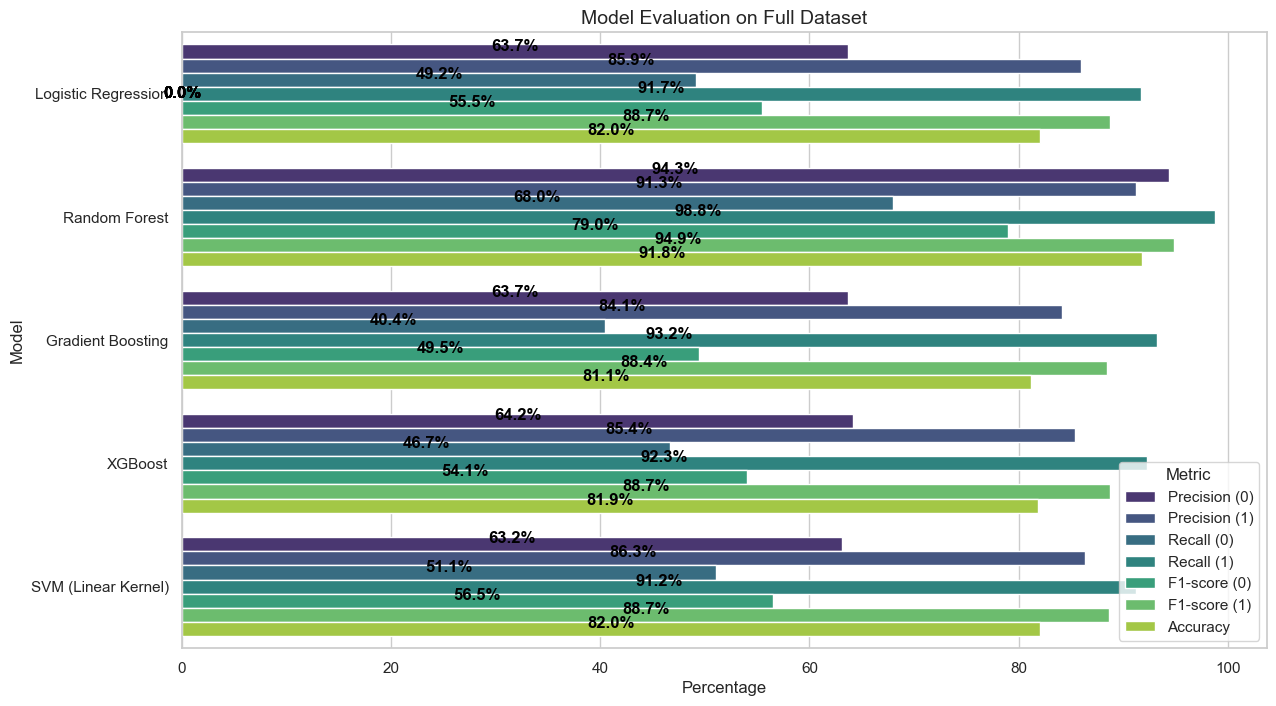

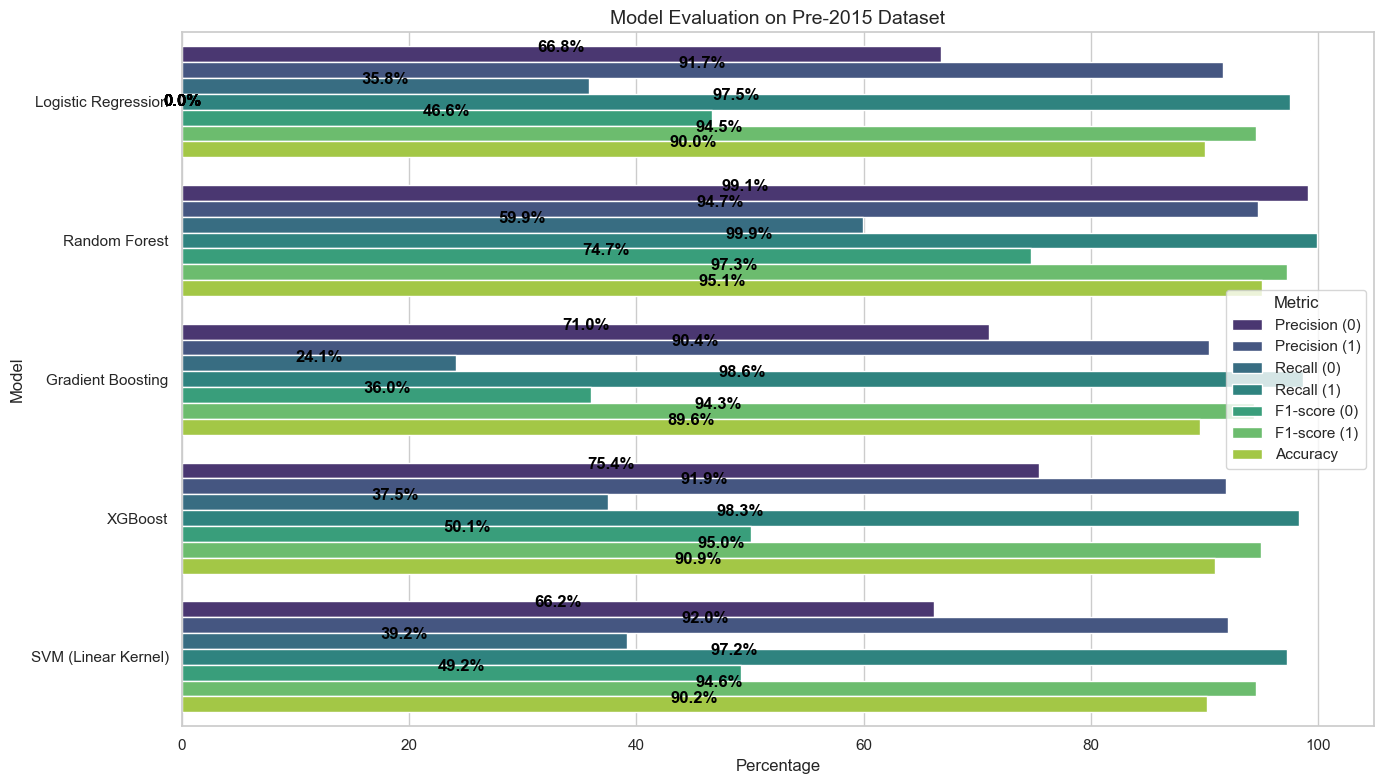

In [68]:
# Convert 'usefulCount' to a binary target variable
df1['useful_binary'] = (df1['usefulCount'] > 5).astype(int)
df1_pre2015['useful_binary'] = (df1_pre2015['usefulCount'] > 5).astype(int)

# Ensure all text data is a string in both datasets
df1['lemmatized_review'] = df1['lemmatized_review'].astype(str)
df1_pre2015['lemmatized_review'] = df1_pre2015['lemmatized_review'].astype(str)

# Prepare data for modeling (already filtered datasets)
def prepare_data(df):
    X = df[['lemmatized_review', 'drugName', 'condition', 'rating']]
    y = df['useful_binary']
    return X, y

# Split the data for the full dataset (df1)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(*prepare_data(df1), test_size=0.2, random_state=42)

# Split the data for the filtered pre-2015 dataset (df1_pre2015)
X_train_pre2015, X_test_pre2015, y_train_pre2015, y_test_pre2015 = train_test_split(*prepare_data(df1_pre2015), test_size=0.2, random_state=42)

# Define preprocessor with TruncatedSVD for dimensionality reduction on the text data
preprocessor = ColumnTransformer(
    transformers=[
        ('text', make_pipeline(TfidfVectorizer(max_features=5000), TruncatedSVD(n_components=100, random_state=42)), 'lemmatized_review'),
        ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=True), ['drugName', 'condition']),
        ('numerical', StandardScaler(), ['rating'])  # Standard scaling for 'rating'
    ]
)

# Define Naive Bayes preprocessor (no scaling for Naive Bayes)
preprocessor_nb = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=5000), 'lemmatized_review'),
        ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=True), ['drugName', 'condition']),
        ('numerical', 'passthrough', ['rating'])  # No scaling for Naive Bayes
    ]
)

# List of models to try (including Naive Bayes)
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42),
    "SVM (Linear Kernel)": LinearSVC(random_state=42, max_iter=1000, dual=False, tol=1e-5),  # Removed n_jobs
}

# Store results in a list for both datasets
model_results_full = []
model_results_pre2015 = []

# Train and evaluate each model on the full dataset
for model_name, model in models.items():
    print(f"--- {model_name} on Full Dataset ---")
    try:
        # Use appropriate preprocessor based on the model (Naive Bayes uses preprocessor_nb)
        if model_name == "Naive Bayes":
            X_train_transformed = preprocessor_nb.fit_transform(X_train_full)
            X_test_transformed = preprocessor_nb.transform(X_test_full)
        else:
            X_train_transformed = preprocessor.fit_transform(X_train_full)
            X_test_transformed = preprocessor.transform(X_test_full)
        
        # Train the model on the full dataset
        model.fit(X_train_transformed, y_train_full)
        
        # Predict on the test set
        y_pred_full = model.predict(X_test_transformed)
        
        # Get classification report and store relevant metrics
        report_full = classification_report(y_test_full, y_pred_full, output_dict=True)
        model_results_full.append({
            'Model': model_name,
            'Precision (0)': report_full['0']['precision'] * 100,
            'Precision (1)': report_full['1']['precision'] * 100,
            'Recall (0)': report_full['0']['recall'] * 100,
            'Recall (1)': report_full['1']['recall'] * 100,
            'F1-score (0)': report_full['0']['f1-score'] * 100,
            'F1-score (1)': report_full['1']['f1-score'] * 100,
            'Accuracy': report_full['accuracy'] * 100
        })
    except Exception as e:
        print(f"Error with {model_name}: {e}")
    print("-" * 50)

# Train and evaluate each model on the pre-2015 dataset
for model_name, model in models.items():
    print(f"--- {model_name} on Pre-2015 Dataset ---")
    try:
        # Use appropriate preprocessor based on the model (Naive Bayes uses preprocessor_nb)
        if model_name == "Naive Bayes":
            X_train_transformed = preprocessor_nb.fit_transform(X_train_pre2015)
            X_test_transformed = preprocessor_nb.transform(X_test_pre2015)
        else:
            X_train_transformed = preprocessor.fit_transform(X_train_pre2015)
            X_test_transformed = preprocessor.transform(X_test_pre2015)
        
        # Train the model on the pre-2015 dataset
        model.fit(X_train_transformed, y_train_pre2015)
        
        # Predict on the test set
        y_pred_pre2015 = model.predict(X_test_transformed)
        
        # Get classification report and store relevant metrics
        report_pre2015 = classification_report(y_test_pre2015, y_pred_pre2015, output_dict=True)
        model_results_pre2015.append({
            'Model': model_name,
            'Precision (0)': report_pre2015['0']['precision'] * 100,
            'Precision (1)': report_pre2015['1']['precision'] * 100,
            'Recall (0)': report_pre2015['0']['recall'] * 100,
            'Recall (1)': report_pre2015['1']['recall'] * 100,
            'F1-score (0)': report_pre2015['0']['f1-score'] * 100,
            'F1-score (1)': report_pre2015['1']['f1-score'] * 100,
            'Accuracy': report_pre2015['accuracy'] * 100
        })
    except Exception as e:
        print(f"Error with {model_name}: {e}")
    print("-" * 50)

# Convert results to DataFrame for easier plotting
df_results_full = pd.DataFrame(model_results_full)
df_results_pre2015 = pd.DataFrame(model_results_pre2015)

# Set up the plot style
sns.set(style="whitegrid", palette="muted")

# Function to plot all metrics in the same graph
def plot_metrics(df_results, title, ax):
    metrics = ['Precision (0)', 'Precision (1)', 'Recall (0)', 'Recall (1)', 'F1-score (0)', 'F1-score (1)', 'Accuracy']
    # Melt the DataFrame for easy plotting
    df_melted = df_results.melt(id_vars='Model', value_vars=metrics, 
                                var_name='Metric', value_name='Score')
    sns.barplot(x='Score', y='Model', hue='Metric', data=df_melted, ax=ax, palette='viridis')
    ax.set_title(f'{title}', fontsize=14)
    ax.set_xlabel('Percentage')
    ax.set_ylabel('Model')
    for p in ax.patches:
        ax.annotate(f'{p.get_width():.1f}%', (p.get_x() + p.get_width() / 2., p.get_y() + p.get_height() * 0.1),
                    ha='center', va='center', fontsize=12, color='black', fontweight='bold')

# Plot the results for the full dataset
fig, ax = plt.subplots(figsize=(14, 8))
plot_metrics(df_results_full, 'Model Evaluation on Full Dataset', ax)

# Plot the results for the pre-2015 dataset
fig, ax = plt.subplots(figsize=(14, 8))
plot_metrics(df_results_pre2015, 'Model Evaluation on Pre-2015 Dataset', ax)

plt.tight_layout()
plt.show()


In [70]:
from sklearn.pipeline import make_pipeline
from scipy.sparse import hstack

# Step 1: Convert 'rating' to a binary target variable
df1['effective'] = (df1['rating'] > 3).astype(int)

# Step 2: Prepare text features (lemmatized reviews) and numerical features (usefulCount)
X_text = df1['lemmatized_review'].astype(str)
X_numerical = df1[['usefulCount']]

# Step 3: Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=2000)
X_tfidf = tfidf_vectorizer.fit_transform(X_text)

# Combine TF-IDF features with numerical features
X_features = hstack([X_tfidf, X_numerical])

# Step 4: Prepare the target variable
y = df1['effective']

# Step 5: Split the data
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

# Step 6: Scale numerical features and train logistic regression model
log_reg = LogisticRegression(max_iter=1000)  # Increase iterations

# Create a pipeline for scaling and fitting the model
pipeline = make_pipeline(StandardScaler(with_mean=False), log_reg)  # with_mean=False for sparse matrix
pipeline.fit(X_train, y_train)

# Step 7: Predictions
y_pred = pipeline.predict(X_test)

# Step 8: Classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.72      0.56      0.63      9423
           1       0.88      0.94      0.91     33590

    accuracy                           0.85     43013
   macro avg       0.80      0.75      0.77     43013
weighted avg       0.85      0.85      0.85     43013



In [72]:
# Create a pipeline with scaling and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  
    ('log_reg', LogisticRegression(solver='liblinear', max_iter=1500))
])

# Define an expanded hyperparameter grid
param_grid = {
    'log_reg__C': [0.01, 0.1, 1, 10], 
    'log_reg__max_iter': [10, 50, 100], 
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=3,       # Number of folds
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores for parallel processing
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate metrics on the best model
y_pred = grid_search.best_estimator_.predict(X_test)  
print(classification_report(y_test, y_pred)) 


Best parameters: {'log_reg__C': 0.01, 'log_reg__max_iter': 10}
Best cross-validation score: 0.8550247021214764
              precision    recall  f1-score   support

           0       0.72      0.56      0.63      9423
           1       0.88      0.94      0.91     33590

    accuracy                           0.85     43013
   macro avg       0.80      0.75      0.77     43013
weighted avg       0.85      0.85      0.85     43013



In [ ]:
y = df1['usefulCount']  
X = df1[['review', 'rating', 'drugName', 'condition']]

# Filter out classes with very few samples (min_class_count = 5)
min_class_count = 5
class_counts = y.value_counts()
classes_to_remove = class_counts[class_counts < min_class_count].index
df_filtered = df1[~df1['usefulCount'].isin(classes_to_remove)]

y_filtered = df_filtered['usefulCount']
X_filtered = df_filtered[['review', 'rating', 'drugName', 'condition']]

# Preprocess the data
# Impute missing values for numerical features (ratings)
numerical_imputer = SimpleImputer(strategy='mean')
X_filtered.loc[:, 'rating'] = numerical_imputer.fit_transform(X_filtered[['rating']])

# One-hot encode categorical features (drugName, condition)
categorical_imputer = SimpleImputer(strategy='most_frequent')
X_filtered.loc[:, 'drugName'] = categorical_imputer.fit_transform(X_filtered[['drugName']])
X_filtered.loc[:, 'condition'] = categorical_imputer.fit_transform(X_filtered[['condition']])

# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_encoded = encoder.fit_transform(X_filtered[['drugName', 'condition']])

# Use TfidfVectorizer for text data (review column)
tfidf_vectorizer = TfidfVectorizer(
    max_features=100,  
    stop_words='english',  
    ngram_range=(1, 2),  # Use unigrams and bigrams
    max_df=0.85,  # Ignore terms that appear in more than 85% of the documents
    min_df=5,  # Ignore terms that appear in fewer than 5 documents
)

# Fit the TF-IDF vectorizer on the review column and transform the reviews
X_tfidf = tfidf_vectorizer.fit_transform(X_filtered['review'])

# 4. Combine the TF-IDF matrix with the other features (rating, drugName, condition)
# Now all features are sparse, so we can hstack them
X_combined = hstack([X_tfidf, X_encoded, X_filtered[['rating']].values])

# 5. Train-test split (use stratified sampling to maintain class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered
)

model = RandomForestClassifier(n_estimators=10, random_state=42)

# Fit the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')


In [64]:
df1['useful_binary'] = (df1['usefulCount'] > 5).astype(int)

# Ensure all text data is a string
df1['lemmatized_review'] = df1['lemmatized_review'].astype(str)

# Define features and target
X = df1[['lemmatized_review', 'drugName', 'condition', 'rating']]
y = df1['useful_binary']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessor with TruncatedSVD for dimensionality reduction on the text data
preprocessor = ColumnTransformer(
    transformers=[
        ('text', make_pipeline(TfidfVectorizer(max_features=5000), TruncatedSVD(n_components=100, random_state=42)), 'lemmatized_review'),
        ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=True), ['drugName', 'condition']),
        ('numerical', StandardScaler(), ['rating'])  # Standard scaling for 'rating'
    ]
)

# Transform the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# List of models to try
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42),
    "SVM (Linear Kernel)": LinearSVC(random_state=42, max_iter=1000, dual=False, tol=1e-5),  # Removed n_jobs
}

# Store results in a list
model_results = []

# Train and evaluate each model
for model_name, model in models.items():
    print(f"--- {model_name} ---")
    try:
        # Train the model
        model.fit(X_train_transformed, y_train)
        
        # Predict on the test set
        y_pred = model.predict(X_test_transformed)
        
        # Get classification report and store relevant metrics
        report = classification_report(y_test, y_pred, output_dict=True)
        model_results.append({
            'Model': model_name,
            'Precision (0)': report['0']['precision'],
            'Precision (1)': report['1']['precision'],
            'Recall (0)': report['0']['recall'],
            'Recall (1)': report['1']['recall'],
            'F1-score (0)': report['0']['f1-score'],
            'F1-score (1)': report['1']['f1-score'],
            'Accuracy': report['accuracy']
        })
    except Exception as e:
        print(f"Error with {model_name}: {e}")
    print("-" * 50)



--- Logistic Regression ---
--------------------------------------------------
--- Random Forest ---


KeyboardInterrupt: 

In [ ]:
# Convert 'usefulCount' to a binary target variable
df1['useful_binary'] = (df1['usefulCount'] > 5).astype(int)

# Prepare features and target
X_text = df1['lemmatized_review'].astype(str)
X_numerical = df1[['rating']]
X_tfidf = TfidfVectorizer(max_features=2000).fit_transform(X_text)
X_features = hstack([X_tfidf, X_numerical])

# Target variable: 'useful_binary'
y = df1['useful_binary']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

# Create and train a logistic regression model
model = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=1000))

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


In [ ]:
# Create the binary target variable based on 'usefulCount'
df1['useful_binary'] = (df1['usefulCount'] > 5).astype(int)

# Prepare text, numerical, and categorical features
X_text = df1['lemmatized_review'].astype(str) 
X_numerical = df1[['rating']]  
X_categorical = df1[['drugName', 'condition']]  # Categorical features: drug name and condition

# Convert text data to TF-IDF features
tfidf = TfidfVectorizer(max_features=500)  
X_tfidf = tfidf.fit_transform(X_text)

# Preprocessing pipelines for categorical features (one-hot encoding)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handle missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore')) 
])

# Apply transformation to categorical features
X_categorical_transformed = categorical_transformer.fit_transform(X_categorical)

# Combine text features (TF-IDF), numerical features (rating), and categorical features (one-hot encoded)
X_features = hstack([X_tfidf, X_numerical, X_categorical_transformed])

# Target variable: 'useful_binary'
y = df1['useful_binary']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

# Create and train a Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Print individual metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nIndividual Metric Scores:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


In [ ]:
# Create the binary target variable based on 'usefulCount'
df1['useful_binary'] = (df1['usefulCount'] > 5).astype(int)

# Prepare text, numerical, and categorical features
X_text = df1['lemmatized_review'].astype(str) 
X_numerical = df1[['rating']]  
X_categorical = df1[['drugName', 'condition']]  # Categorical features: drug name and condition

# Convert text data to TF-IDF features
tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1, 2), stop_words='english')  
X_tfidf = tfidf.fit_transform(X_text)

# Preprocessing pipelines for categorical features (one-hot encoding)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handle missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  

# Apply transformation to categorical features
X_categorical_transformed = categorical_transformer.fit_transform(X_categorical)

# Scaling the numerical features
scaler = StandardScaler(with_mean=False)  # Don't center numerical features because of sparse matrix
X_numerical_scaled = scaler.fit_transform(X_numerical)

# Combine text features (TF-IDF), numerical features (scaled rating), and categorical features (one-hot encoded)
X_features = hstack([X_tfidf, X_numerical_scaled, X_categorical_transformed])

# Target variable: 'useful_binary'
y = df1['useful_binary']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

# Create and train a Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')  # Use 'liblinear' for small datasets

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'penalty': ['l2'],  # Regularization type
    'solver': ['liblinear']  # Solver for small datasets
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best hyperparameters found by GridSearchCV
print(f"Best Parameters: {grid_search.best_params_}")

# Get the best model
best_model = grid_search.best_estimator_

# Train the best model
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test)

# Print individual metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nIndividual Metric Scores:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


In [ ]:
# Add interaction feature between drugName and condition (casting to str)
df1['drug_condition'] = df1['drugName'].astype(str) + "_" + df1['condition'].astype(str)

# Preprocessing for text, numerical, and categorical features
X_text = df1['lemmatized_review'].astype(str)  
X_numerical = df1[['rating']]  
X_categorical = df1[['drugName', 'condition', 'drug_condition']]  # Categorical features: drug name, condition, and the interaction feature

# TF-IDF vectorizer (advanced settings)
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 3), stop_words='english')  # Include trigrams
X_tfidf = tfidf.fit_transform(X_text)

# Preprocessing for categorical features (one-hot encoding)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handle missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  
X_categorical_transformed = categorical_transformer.fit_transform(X_categorical)

# Scaling the numerical features
scaler = StandardScaler(with_mean=False)  # Don't center numerical features because of sparse matrix
X_numerical_scaled = scaler.fit_transform(X_numerical)

# Combine all features: text (TF-IDF), numerical (scaled rating), and categorical (one-hot encoded)
X_features = hstack([X_tfidf, X_numerical_scaled, X_categorical_transformed])

# Target variable: 'useful_binary'
y = df1['useful_binary']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

# Logistic Regression model with hyperparameter tuning
model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear', class_weight='balanced')

# Define hyperparameters for grid search
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # Regularization type
    'solver': ['liblinear', 'saga']  # Solvers for small to medium datasets
}

# GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best hyperparameters found by GridSearchCV
print(f"Best Parameters: {grid_search.best_params_}")

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Train the best model
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
print("\nIndividual Metric Scores:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate Precision-Recall AUC (PR AUC)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
print(f"\nPR AUC: {pr_auc:.4f}")


In [ ]:
# Convert 'usefulCount' to a binary target variable
df1['useful_binary'] = (df1['usefulCount'] > 5).astype(int)

# Ensure all text data is a string
df1['lemmatized_review'] = df1['lemmatized_review'].astype(str)

# Define features and target
X = df1[['lemmatized_review', 'drugName', 'condition', 'rating']]
y = df1['useful_binary']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessor with TruncatedSVD for dimensionality reduction on the text data
preprocessor = ColumnTransformer(
    transformers=[
        ('text', make_pipeline(TfidfVectorizer(max_features=5000), TruncatedSVD(n_components=100, random_state=42)), 'lemmatized_review'),
        ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=True), ['drugName', 'condition']),
        ('numerical', StandardScaler(), ['rating'])  # Standard scaling for 'rating'
    ]
)

# Transform the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# List of models to try
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42),
    "SVM (Linear Kernel)": LinearSVC(random_state=42, max_iter=1000, dual=False, tol=1e-5),  # Removed n_jobs
    
}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"--- {model_name} ---")
    try:
        # Train the model
        model.fit(X_train_transformed, y_train)
        
        # Predict on the test set
        y_pred = model.predict(X_test_transformed)
        
        # Evaluate the model
        print(classification_report(y_test, y_pred))
    except Exception as e:
        print(f"Error with {model_name}: {e}")
    print("-" * 50)


In [ ]:
preprocessor_nb = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=5000), 'lemmatized_review'),
        ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=True), ['drugName', 'condition']),
        ('numerical', 'passthrough', ['rating']) 
    ]
)

X_train_transformed_nb = preprocessor_nb.fit_transform(X_train)
X_test_transformed_nb = preprocessor_nb.transform(X_test)

# Train and evaluate
print("--- Naive Bayes ---")
try:
    model_nb = MultinomialNB()
    model_nb.fit(X_train_transformed_nb, y_train)
    y_pred_nb = model_nb.predict(X_test_transformed_nb)
    print(classification_report(y_test, y_pred_nb))
except Exception as e:
    print(f"Error with Naive Bayes: {e}")
print("-" * 50)


In [ ]:
# Define models
gb_model = GradientBoostingClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42, scale_pos_weight=class_weight_dict[1])

# Define parameter grids
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8]
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1],
    'max_depth': [3, 6],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# RandomizedSearchCV for Gradient Boosting
random_search_gb = RandomizedSearchCV(gb_model, param_grid_gb, cv=5, scoring='accuracy', n_jobs=-1, n_iter=10)
random_search_gb.fit(X_train, y_train)

# Best parameters from random search
print(f"Best Parameters for Gradient Boosting: {random_search_gb.best_params_}")
best_gb_model = random_search_gb.best_estimator_

# Evaluate Gradient Boosting model
y_pred_gb = best_gb_model.predict(X_test)
print("\nGradient Boosting Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_gb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_gb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_gb):.4f}")
print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))

precision_gb, recall_gb, _ = precision_recall_curve(y_test, y_pred_gb)
pr_auc_gb = auc(recall_gb, precision_gb)
print(f"PR AUC (Gradient Boosting): {pr_auc_gb:.4f}")

# RandomizedSearchCV for XGBoost
random_search_xgb = RandomizedSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1, n_iter=10)
random_search_xgb.fit(X_train, y_train)

# Best parameters from random search
print(f"Best Parameters for XGBoost: {random_search_xgb.best_params_}")
best_xgb_model = random_search_xgb.best_estimator_

# Evaluate XGBoost model
y_pred_xgb = best_xgb_model.predict(X_test)
print("\nXGBoost Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_xgb):.4f}")
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_xgb)
pr_auc_xgb = auc(recall_xgb, precision_xgb)
print(f"PR AUC (XGBoost): {pr_auc_xgb:.4f}")


In [ ]:
# Vectorizing the text using TF-IDF with min_df to exclude rare words
tfidf_vectorizer = TfidfVectorizer(
    stop_words='english', 
    max_features=2000,  # Limit the number of features (terms) for efficiency
    min_df=5            # Exclude words that appear in fewer than 5 documents
)

X_tfidf = tfidf_vectorizer.fit_transform(df1['lemmatized_review'].astype(str))

# Applying LDA with 5 topics, using n_jobs=-1 for parallelization and learning_method='online' for faster convergence
lda = LatentDirichletAllocation(
    n_components=5,       # Number of topics
    random_state=42,
    n_jobs=-1,            
    max_iter=10,          
    learning_method='online',  
    batch_size=128,       
    evaluate_every=-1,    
    verbose=0             # Silence output to speed up execution
)

# Fit LDA to the entire TF-IDF matrix
lda_fit = lda.fit_transform(X_tfidf)

# Get the top words for each topic
def get_top_words(model, feature_names, n_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append(" ".join(topic_words))
    return topics

top_words = get_top_words(lda, tfidf_vectorizer.get_feature_names_out(), n_top_words=10)

# Print the top words for each topic
for i, topic in enumerate(top_words):
    print(f"Topic {i + 1}: {topic}")

# Visualize the topic distribution (using a subset of reviews if necessary to avoid crowding)
topic_distribution = pd.DataFrame(lda_fit, columns=[f"Topic {i+1}" for i in range(5)])

# Set up the heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size for better readability
sns.heatmap(topic_distribution, cmap="coolwarm", annot=False, cbar=True, linewidths=0.5)

# Customize the axes to improve readability
plt.title("Topic Distribution for Reviews", fontsize=16)
plt.xlabel("Topic", fontsize=12)
plt.ylabel("Review Index", fontsize=12)
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better spacing
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
plt.tight_layout()  # Ensure the labels fit inside the figure area

# Show the plot
plt.show()


In [ ]:
import umap
from sklearn.decomposition import PCA

# Vectorizing the text using TF-IDF 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=2000)
X_tfidf = tfidf_vectorizer.fit_transform(df1['lemmatized_review'].astype(str))

# Step 1: Use PCA to reduce dimensions before UMAP 
pca = PCA(n_components=100, random_state=42)  
X_pca = pca.fit_transform(X_tfidf.toarray())

# Step 2: Apply UMAP on the PCA-reduced data (UMAP is much faster than t-SNE)
# Remove random_state to enable parallel processing
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
X_umap = umap_model.fit_transform(X_pca)

# Step 3: Create a DataFrame for visualization
umap_df = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])

# Step 4: Visualize the UMAP results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', data=umap_df, alpha=0.7, marker='o')
plt.title('UMAP Visualization of Reviews')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

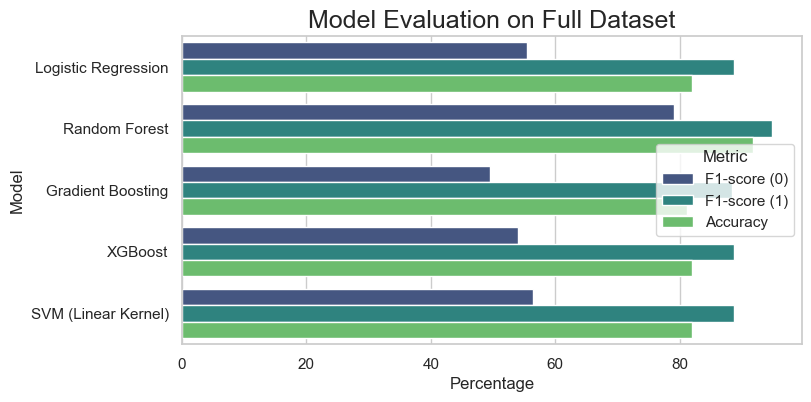

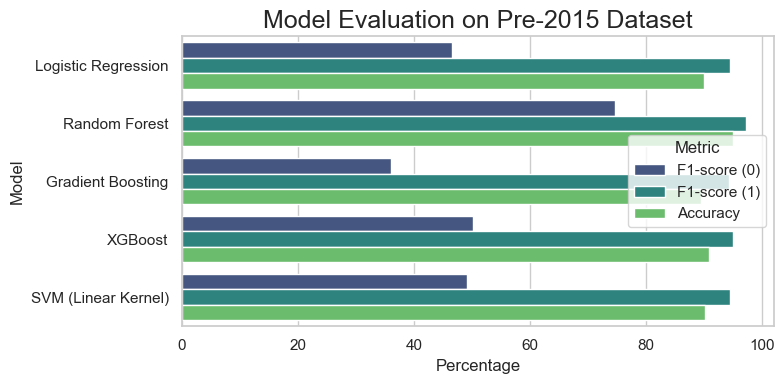

In [74]:
# Set up the plot style
sns.set(style="whitegrid", palette="muted")

# Function to plot all metrics in the same graph
def plot_metrics(df_results, title, ax):
    metrics = ['F1-score (0)', 'F1-score (1)', 'Accuracy']
    # Melt the DataFrame for easy plotting
    df_melted = df_results.melt(id_vars='Model', value_vars=metrics, 
                                var_name='Metric', value_name='Score')
    sns.barplot(x='Score', y='Model', hue='Metric', data=df_melted, ax=ax, palette='viridis')
    ax.set_title(f'{title}', fontsize=18)
    ax.set_xlabel('Percentage')
    ax.set_ylabel('Model')

# Plot the results for the full dataset
fig, ax = plt.subplots(figsize=(8, 4))
plot_metrics(df_results_full, 'Model Evaluation on Full Dataset', ax)

# Plot the results for the pre-2015 dataset
fig, ax = plt.subplots(figsize=(8, 4))
plot_metrics(df_results_pre2015, 'Model Evaluation on Pre-2015 Dataset', ax)

plt.tight_layout()
plt.show()


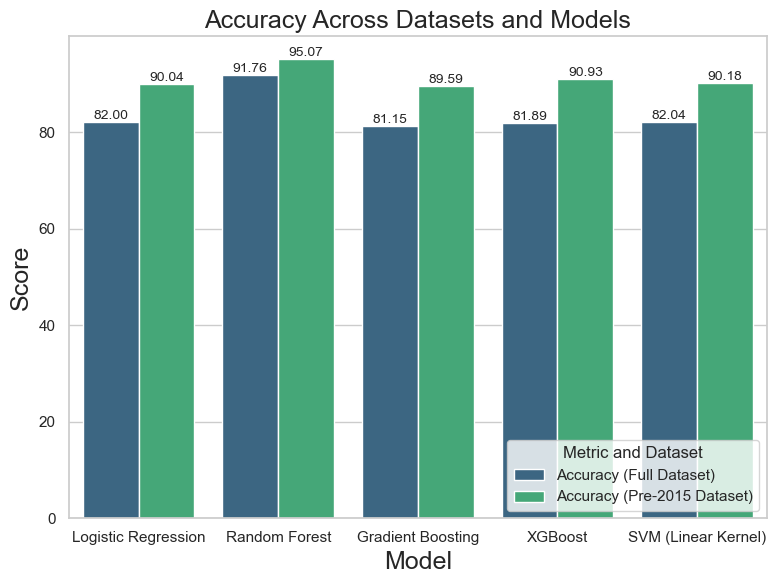

In [76]:
# Set up the plot style
sns.set(style="whitegrid", palette="muted")

# Combine both datasets into one for a single plot
df_results_full['Dataset'] = 'Full Dataset'
df_results_pre2015['Dataset'] = 'Pre-2015 Dataset'
df_combined = pd.concat([df_results_full, df_results_pre2015])

# Melt the DataFrame for easy plotting
metrics = ['Accuracy']
df_melted = df_combined.melt(id_vars=['Model', 'Dataset'], value_vars=metrics, 
                             var_name='Metric', value_name='Score')

# Create a combined column for hue
df_melted['Metric-Dataset'] = df_melted['Metric'] + ' (' + df_melted['Dataset'] + ')'

# Plot all metrics in the same graph, side by side
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Model', y='Score', hue='Metric-Dataset', data=df_melted, 
                 palette='viridis', errorbar=None, dodge=True)

# Annotate each bar with its value
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10)

# Add titles and labels
plt.title('Accuracy Across Datasets and Models', fontsize=18)
plt.xlabel('Model', fontsize=18)
plt.ylabel('Score', fontsize=18)
plt.legend(title='Metric and Dataset', loc='lower right')

plt.tight_layout()
plt.show()


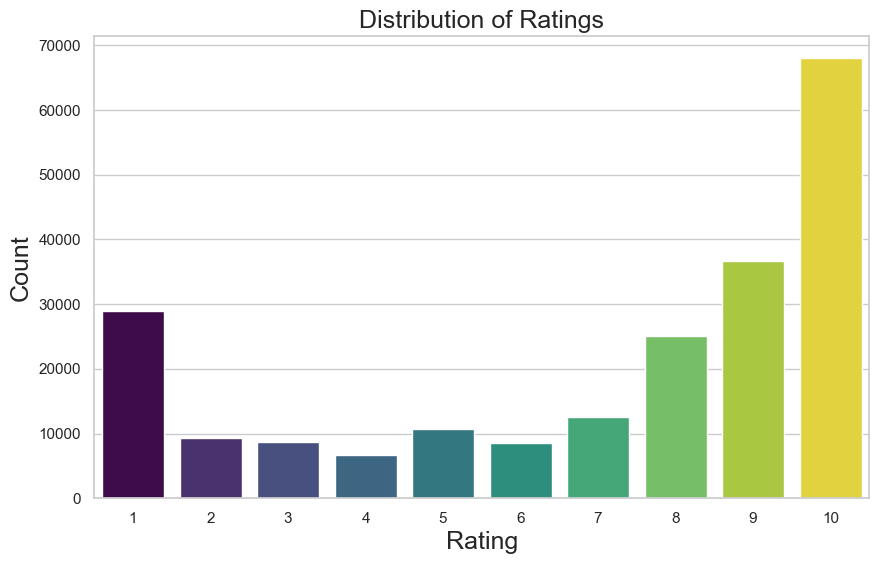

In [78]:
# Distribution of Ratings
#plt.subplot(3, 2, 1)
plt.figure(figsize=(10, 6))

sns.countplot(data=df1, x='rating', hue='rating', palette='viridis', legend=False)
plt.title('Distribution of Ratings', fontsize=18)
plt.xlabel('Rating', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.show()